In [1]:
!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 11.5MB 2.6MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 22.9MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 20.3MB 1.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.6.0.html
     |████████████████████████████████| 6.1MB 2.2MB/s 
     |████████████████████████████████| 184kB 2.9MB/s 
     |████████████████████████████████| 235kB 8.7MB/s 
     |████████████████████████████████| 2.2MB 9.1MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.1-cp36-none-any.whl size=308552 sha256=1cdfad5cb79f4c4245f34e71c3a5b6b2499391cd6d8bdcdeee0e63de04cb3466
  Stored in directory: /root/.cache/pip/wheels/e6/25/ea/3d71d2088dccc63214fa59259dcc598ded4150a5f8b41d84ff
Succe

In [138]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

from sklearn.preprocessing import LabelEncoder

## ランダムデータセットを作成

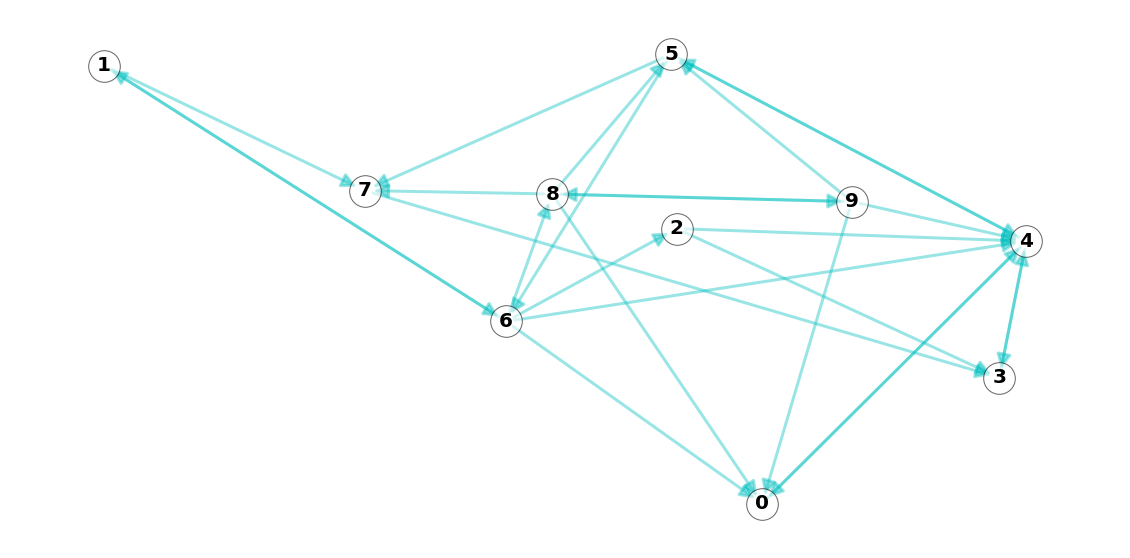

In [3]:
G = nx.fast_gnp_random_graph(n=10, p=0.2, directed=True)
plt.figure(figsize=(20, 10))
plt.axis('off')
pos = nx.spring_layout(G, k=0.9)
nx.draw_networkx_nodes(G, pos, node_color="w", alpha=0.6, node_size=1000, edgecolors="k")
nx.draw_networkx_labels(G, pos, font_size=20, font_weight="bold")
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color="c", width=3, arrowsize=30)
plt.show()

In [108]:
class RandomDataset(InMemoryDataset): 
    def __init__(self, root, name, config, transform=None, pre_transform=None):
        self.root = root
        self.name = name
        
        self.n_dataset = config['n_dataset']
        self.min_node = config['min_node']
        self.max_node = config['max_node']
        self.p = config['p']
        self.n_node_features = config['n_node_features']
        self.n_label = config['n_label']

        super(RandomDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return [self.root + self.name]

    def download(self):
        pass
    
    def process(self):
        data_list = []

        while len(data_list) <= n_dataset:
            n = np.random.randint(self.min_node, self.max_node)
            g = nx.fast_gnp_random_graph(n=n, p=self.p, directed=True)
            if len(g.edges()) > 2:
                from_nodes = np.array(g.edges).T[0]
                to_nodes = np.array(g.edges).T[1]

                n_nodes = len(np.unique(np.concatenate([from_nodes, to_nodes])))

                node_encoder = LabelEncoder()
                node_encoder.fit_transform(np.concatenate([from_nodes, to_nodes]))
                from_nodes = node_encoder.transform(from_nodes)
                to_nodes = node_encoder.transform(to_nodes)
                edge_index = torch.tensor([from_nodes, to_nodes], dtype=torch.long)

                node_features = np.random.rand(n_nodes, self.n_node_features)
                x = torch.FloatTensor(node_features)

                y = torch.tensor(np.random.randint(0, self.n_label, size=1), dtype=torch.long)

                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [110]:
config = {'n_dataset': 100,
          'min_node': 5,
          'max_node': 10,
          'p': 0.6,
          'n_node_features': 3,
          'n_label': 3
          }
dataset = RandomDataset(root='/content/drive/My Drive/fueki/GNN/dataset/Random', name='/random4.dataset', config=config)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

Processing...
Done!


## torch_geometric.nn

In [119]:
data = next(iter(dataloader))
print(data.x.shape)
print(data.x)

torch.Size([35, 3])
tensor([[0.9849, 0.3564, 0.3158],
        [0.4355, 0.6913, 0.6091],
        [0.6522, 0.5786, 0.0015],
        [0.7777, 0.4895, 0.2654],
        [0.8471, 0.6204, 0.1072],
        [0.9257, 0.1237, 0.4017],
        [0.7245, 0.2610, 0.0904],
        [0.4901, 0.1871, 0.7004],
        [0.7640, 0.8481, 0.1021],
        [0.0257, 0.7737, 0.3974],
        [0.1002, 0.7816, 0.1219],
        [0.8094, 0.0066, 0.9171],
        [0.4563, 0.6682, 0.8894],
        [0.8658, 0.6443, 0.8603],
        [0.4625, 0.4404, 0.8842],
        [0.6120, 0.3855, 0.1375],
        [0.8861, 0.2026, 0.1913],
        [0.9219, 0.6154, 0.8356],
        [0.0614, 0.0100, 0.1881],
        [0.3491, 0.3471, 0.1297],
        [0.4652, 0.6530, 0.8455],
        [0.5657, 0.7855, 0.8538],
        [0.9753, 0.5582, 0.7855],
        [0.8676, 0.3527, 0.8579],
        [0.3774, 0.9043, 0.4285],
        [0.9766, 0.6132, 0.8357],
        [0.0385, 0.6801, 0.3610],
        [0.1993, 0.4892, 0.9542],
        [0.4615, 0.8411, 0.6

### torch_geometric.nn.GCNConv

In [ ]:
gconv = gnn.GCNConv(in_channels=3, out_channels=5)
gconv

頂点数は変わらず、頂点の特徴ベクトルが3次元から5次元に変換される

In [121]:
print(gconv(data.x, data.edge_index).shape)
print(gconv(data.x, data.edge_index))

torch.Size([35, 5])
tensor([[ 0.1688, -0.3229, -0.8528, -0.0997, -0.6001],
        [ 0.1716, -0.3533, -0.9042, -0.1100, -0.5922],
        [ 0.1704, -0.3415, -0.8712, -0.1344, -0.4857],
        [ 0.1445, -0.3734, -0.8799, -0.1075, -0.4887],
        [ 0.0958, -0.3589, -0.7745, -0.0546, -0.4579],
        [ 0.2037, -0.1796, -0.6666, -0.1563, -0.4551],
        [ 0.1749, -0.1080, -0.5179, -0.0860, -0.5477],
        [ 0.1519, -0.2663, -0.7240, -0.0973, -0.4959],
        [ 0.1496, -0.3468, -0.8505, -0.0997, -0.5261],
        [-0.0351, -0.5994, -0.9366,  0.0542, -0.4189],
        [ 0.0182, -0.5731, -0.9888,  0.0100, -0.4799],
        [-0.0512, -0.7268, -1.1132,  0.0575, -0.4361],
        [-0.0206, -0.5254, -0.8321,  0.0233, -0.3215],
        [-0.0359, -0.7667, -1.2150,  0.0637, -0.5562],
        [-0.0540, -0.6738, -1.0055,  0.0259, -0.2682],
        [-0.0630, -0.6212, -0.9235,  0.0794, -0.4000],
        [-0.0072, -0.6386, -1.0491,  0.0268, -0.4671],
        [ 0.0023, -0.5639, -0.9501,  0.0343, 

### torch_geometric.nn.GraphConv

In [122]:
gconv = gnn.GraphConv(in_channels=3, out_channels=5)
gconv

GraphConv(3, 5)

頂点数は変わらず、頂点の特徴ベクトルが3次元から5次元に変換される

In [123]:
print(gconv(data.x, data.edge_index).shape)
print(gconv(data.x, data.edge_index))

torch.Size([35, 5])
tensor([[-1.8855e-02, -1.1116e+00,  2.3790e+00,  1.0569e+00,  3.8073e-01],
        [-6.9639e-01, -1.6215e+00,  3.3999e+00,  1.0295e+00,  7.3785e-01],
        [-5.3629e-01, -1.4024e+00,  2.4295e+00,  8.9669e-01,  5.5838e-01],
        [-4.6165e-01, -1.2005e+00,  2.3839e+00,  8.5195e-01,  4.7759e-01],
        [ 1.0637e-01, -5.9705e-01,  1.8239e+00,  9.1062e-01, -1.3056e-01],
        [-5.2769e-02, -9.5370e-01,  1.4908e+00,  5.4690e-01,  5.4243e-01],
        [ 5.8106e-01, -5.4947e-01,  1.3636e+00,  8.5595e-01, -2.5517e-02],
        [-1.7824e-01, -9.1218e-01,  2.1474e+00,  6.6180e-01,  4.7323e-01],
        [-3.1449e-01, -1.1762e+00,  2.5103e+00,  1.0052e+00,  2.4241e-01],
        [-2.5433e-01, -3.2180e-01,  2.6468e+00,  9.9821e-01, -4.3105e-01],
        [-4.4006e-01, -7.5158e-01,  2.9904e+00,  1.1853e+00, -1.7960e-01],
        [-2.0354e-01,  1.8177e-01,  1.9878e+00,  7.4641e-01, -3.9049e-01],
        [-2.0480e-01,  5.0818e-02,  1.8462e+00,  5.0326e-01, -4.3329e-01],
     

### torch_geometric.nn.TopKPooling

In [128]:
# pool = gnn.TopKPooling(in_channels=3, ratio=0.5)
# pool(data.x, edge_index)

(tensor([[4.3641e-01, 9.9787e-02, 9.4227e-02],
         [4.4420e-01, 5.9369e-02, 1.9277e-01],
         [4.5447e-01, 1.6447e-01, 1.4570e-01],
         [2.9011e-01, 1.0453e-01, 3.6212e-02],
         [2.8715e-01, 2.1029e-01, 3.6342e-02],
         [2.5540e-01, 1.1955e-02, 2.6170e-01],
         [2.2207e-01, 1.3976e-01, 7.5782e-02],
         [1.8035e-01, 8.2046e-03, 1.5412e-01],
         [2.1903e-01, 1.7844e-03, 2.4818e-01],
         [1.5531e-01, 9.7815e-02, 3.4896e-02],
         [1.6489e-01, 1.4628e-01, 3.8454e-04],
         [2.0470e-01, 1.1716e-01, 1.6486e-01],
         [1.6380e-01, 6.6592e-02, 1.6198e-01],
         [1.4029e-01, 1.5573e-01, 1.8753e-02],
         [1.6374e-01, 1.0280e-01, 1.4011e-01],
         [1.1425e-01, 7.6270e-02, 1.0356e-01],
         [2.4417e-02, 2.4275e-02, 9.0724e-03],
         [4.9227e-02, 3.6635e-02, 4.8914e-02]], grad_fn=<MulBackward0>),
 tensor([[ 2,  2,  2, 10, 10, 10, 10,  6,  6,  6,  4,  4,  4,  4,  1,  1,  1,  1,
           3,  3,  3],
         [10,  6,  3,  

### torch_geometric.nn.GIN

In [139]:
in_channel = 3
out_channel = 5
nn_ = nn.Sequential(nn.Linear(in_channel, out_channel), nn.ReLU(), nn.Linear(out_channel, out_channel))
gin = gnn.GINConv(nn_)
gin

GINConv(nn=Sequential(
  (0): Linear(in_features=3, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
))

In [140]:
print(gin(data.x, data.edge_index).shape)
print(gin(data.x, data.edge_index))

torch.Size([35, 5])
tensor([[ 2.0857e-01, -4.0593e-01, -7.3516e-02, -1.3323e-01, -6.3070e-02],
        [ 2.1681e-01, -3.9714e-01, -6.4506e-02, -1.4847e-01, -6.0288e-02],
        [ 2.1501e-01, -3.9907e-01, -6.6482e-02, -1.4513e-01, -6.0898e-02],
        [ 1.9542e-01, -4.1997e-01, -8.7891e-02, -1.0892e-01, -6.7510e-02],
        [ 1.5136e-01, -5.1553e-01, -7.2099e-02, -6.1422e-02, -6.4036e-02],
        [ 1.8033e-01, -3.7313e-01, -5.4864e-02, -2.0852e-01, -3.4725e-02],
        [ 1.1061e-01, -4.4632e-01,  3.3291e-02, -2.9371e-01,  1.8551e-02],
        [ 2.0466e-01, -4.1387e-01, -7.2827e-02, -1.2864e-01, -6.2966e-02],
        [ 1.9424e-01, -4.2122e-01, -8.9175e-02, -1.0675e-01, -6.7906e-02],
        [ 1.5985e-02, -7.9852e-01, -3.7619e-02,  9.1991e-02, -5.7393e-02],
        [ 4.2757e-02, -7.1381e-01, -8.2297e-02,  8.1751e-02, -6.9568e-02],
        [-3.7578e-02, -8.4577e-01, -1.0922e-01,  1.9794e-01, -7.9220e-02],
        [ 4.5039e-02, -7.0736e-01, -8.5093e-02,  8.0341e-02, -7.0315e-02],
     